# TLT SSD example usecase

本教程将详细讲述如何利用NVIDIA Transfer Learning toolkit从头开始训练一个口罩检测的模型，并将模型转换成可以直接部署在NVIDIA GPU（Tesla & Jetson）上的格式.

0. [设置环境变量](#head-0)
1. [准备数据集和预训练模型](#head-1) <br>
    1.1 [将数据集转换成KITTI格式并生成TFrecord文件](#head-1-1) <br>
    1.2 [下载预训练模型](#head-1-2) <br>
2. [设置训练参数](#head-2)
3. [利用NVIDIA Transfer Learning Toolkit训练模型](#head-3)
4. [评估模型](#head-4)
5. [模型剪枝](#head-5)
6. [重新训练剪枝后的模型](#head-6)
7. [评估重新训练的模型](#head-7)
8. [可视化推理过程](#head-8)
9. [模型的导出和部署](#head-9)
10. [确认导出模型](#head-10)

## 0. 设置环境变量 <a class="anchor" id="head-0"></a>


In [1]:
# 设置环境变量，这里请注意KEY是需要您从NGC官网申请的，您可以从以下网址得到您自己的KEY：
#https://ngc.nvidia.com/catalog
#USER_EXPERIMENT_DIR是我们实验的目录
#DATA_DOWNLOAD_DIR是用来保存我们的数据样本和预训练模型
#SPECS_DIR是用来保存我们训练设置的超参
#以下设置仅代表作者本人的设置目录，需要用户根据自己的实际情况设置更新
print("Please replace the variable with your key.")
%set_env KEY=OHB1YTZ0Z2RxYTBzdnE3YTNpcnVydmM4cXI6MDM5MjNmZmUtYzFkMS00ZDFhLWIyOGEtM2M5N2RkZGZjNDZm
%set_env USER_EXPERIMENT_DIR=/workspace/tlt_docker_files/mydata/tlt-tensorrt-nano
%set_env DATA_DOWNLOAD_DIR=/workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data
%set_env SPECS_DIR=/workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs
!mkdir -p $USER_EXPERIMENT_DIR
!mkdir -p $DATA_DOWNLOAD_DIR
!mkdir -p $SPECS_DIR

Please replace the variable with your key.
env: KEY=OHB1YTZ0Z2RxYTBzdnE3YTNpcnVydmM4cXI6MDM5MjNmZmUtYzFkMS00ZDFhLWIyOGEtM2M5N2RkZGZjNDZm
env: USER_EXPERIMENT_DIR=/workspace/tlt_docker_files/mydata/tlt-tensorrt-nano
env: DATA_DOWNLOAD_DIR=/workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data
env: SPECS_DIR=/workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs


## 1. 准备训练数据集和下载预训练模型 <a class="anchor" id="head-1"></a>

In [2]:
#验证KEY是否设置成功，这个KEY非常重要，用户训练出来的模型在导出和转换时都需要
!echo $KEY

OHB1YTZ0Z2RxYTBzdnE3YTNpcnVydmM4cXI6MDM5MjNmZmUtYzFkMS00ZDFhLWIyOGEtM2M5N2RkZGZjNDZm


 NVIDIA官方教程中使用的KITTI目标检测数据集，您可以通过以下网址下载：
 http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d.
 
 图片下载网址： (http://www.cvlibs.net/download.php?file=data_object_image_2.zip) 
 
 标注下载网址： (http://www.cvlibs.net/download.php?file=data_object_label_2.zip) 
 
 下载好之后，把数据集放到$DATA_DOWNLOAD_DIR文件夹中.

In [3]:
# 查看上面下载的数据----这步当前实验可以不运行
!mkdir -p $DATA_DOWNLOAD_DIR
!if [ ! -f $DATA_DOWNLOAD_DIR/data_object_image_2.zip ]; then echo 'Image zip file not found, please download.'; else echo 'Found Image zip file.';fi
!if [ ! -f $DATA_DOWNLOAD_DIR/data_object_label_2.zip ]; then echo 'Label zip file not found, please download.'; else echo 'Found Labels zip file.';fi

Found Image zip file.
Found Labels zip file.


In [3]:
# 解压----这步当前实验可以不运行
# !unzip -u $DATA_DOWNLOAD_DIR/data_object_image_2.zip -d $DATA_DOWNLOAD_DIR
# !unzip -u $DATA_DOWNLOAD_DIR/data_object_label_2.zip -d $DATA_DOWNLOAD_DIR

Archive:  /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/data_object_image_2.zip
   creating: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002480.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005952.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000709.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000814.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006192.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006017.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002731.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005295.png  
 extracting

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004036.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006216.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001394.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000894.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003293.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002474.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006360.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007271.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004064.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001020.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005582.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000965.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000313.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002161.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000969.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002599.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006832.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003783.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002012.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000734.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006507.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002726.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001339.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004212.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007037.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003928.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002506.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003826.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000740.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002402.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006029.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004177.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005802.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005150.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004807.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001940.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001783.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000878.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006431.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006157.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006241.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007246.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005724.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005337.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006526.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007322.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006509.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006576.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000516.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000573.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000773.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003766.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000035.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000557.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006934.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001753.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006897.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000862.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005423.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006936.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001070.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005035.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002432.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002334.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003060.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000152.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000935.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002686.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007223.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004739.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003616.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006773.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005989.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004594.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005901.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004850.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000018.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006559.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005322.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001232.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002888.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003552.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003245.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005335.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007477.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002780.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002607.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004609.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000003.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000569.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005780.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005661.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003764.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004670.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005219.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005397.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001281.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000111.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006918.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006986.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001082.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006200.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002475.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001769.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004137.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002476.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004740.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001310.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004076.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006841.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006281.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003303.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006998.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007279.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001966.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000786.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005767.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004971.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000048.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006372.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001611.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001019.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001207.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006525.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003745.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005273.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004159.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002647.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001967.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000370.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005913.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002987.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005172.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001666.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003039.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002046.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006849.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001028.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001237.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001830.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002431.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003430.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003494.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004188.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007397.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002692.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006852.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004380.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004945.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004334.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002881.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001199.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001509.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002369.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005969.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001441.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006572.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003190.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005740.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002208.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000914.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001634.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002904.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006546.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004706.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003286.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000060.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001377.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000149.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002902.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003703.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001775.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006812.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003201.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006483.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006825.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006032.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003957.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003597.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002717.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002968.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005588.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002957.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005057.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002727.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005009.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007085.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006410.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007009.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006127.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005145.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001781.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006468.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003994.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004004.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004412.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001415.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005051.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002600.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003666.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001816.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003707.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001994.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006132.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005627.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004538.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002167.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000402.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005324.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003723.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001395.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006799.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003684.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007375.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000666.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002149.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007374.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003100.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001375.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001585.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007415.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003884.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005700.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003364.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004891.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006464.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005503.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000501.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004863.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005879.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000129.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007240.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006130.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006917.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001378.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001640.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000130.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007361.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000159.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001897.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002303.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007382.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002975.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002829.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006165.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002396.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004962.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003671.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003460.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000988.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003207.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001554.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004806.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001004.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001799.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000905.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004037.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006976.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000830.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007446.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005528.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003777.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002074.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002215.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006870.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001601.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000527.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001592.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000438.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002952.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002572.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004485.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004104.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001616.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002584.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002543.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002185.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006025.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001423.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000499.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006452.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006443.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005967.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005403.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005619.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002694.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007329.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001335.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005634.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005607.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001106.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001003.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004417.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000554.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004937.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004419.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000426.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006451.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001094.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006419.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000835.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005262.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004352.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001965.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001472.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003592.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004016.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005443.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003908.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001029.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004656.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002252.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000744.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002565.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002006.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006977.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000193.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006230.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006543.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000698.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002204.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007369.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003092.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003258.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001473.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003544.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003851.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006107.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003976.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006434.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001412.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004058.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006737.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000280.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003754.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003221.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004326.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002328.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000769.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002042.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007448.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005007.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005367.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007480.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005411.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002566.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007273.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007321.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002292.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007349.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001778.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000892.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001130.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003145.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002526.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006016.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001573.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000581.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006409.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001576.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004676.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007465.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002179.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003407.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002017.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001591.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003741.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002015.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005483.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002619.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000674.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002663.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000054.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000397.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003093.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002169.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001180.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003613.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006640.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000332.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000576.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002357.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002587.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006989.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000908.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006545.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001128.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002548.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001152.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000327.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007208.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001889.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002912.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006966.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003803.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000429.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006955.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004725.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005772.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004241.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000127.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004788.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004521.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001153.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007454.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001687.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006921.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003867.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005673.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004784.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000478.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001000.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000134.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006549.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005936.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006829.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005895.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003519.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000951.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000970.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006031.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001054.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003789.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003172.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001846.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005586.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007182.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000668.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006045.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000730.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000945.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005445.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005430.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003203.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006321.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001925.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007440.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003582.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003353.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005159.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002873.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004651.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000176.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000886.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001945.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002746.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001560.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005894.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000736.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001032.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000933.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003830.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007401.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002009.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006588.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006308.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002802.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005479.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006233.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005855.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004062.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007136.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006960.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000472.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006371.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004367.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006715.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005348.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001487.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005523.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004245.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004279.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003537.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006030.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000121.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000918.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006865.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004701.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001403.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000790.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000983.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003522.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002022.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004029.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004296.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005378.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006183.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005752.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003399.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004699.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001983.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002253.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004775.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006037.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005827.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004557.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006709.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000086.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001521.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002035.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006271.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002397.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003734.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006672.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004141.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001565.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007119.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006910.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000552.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005711.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005129.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000215.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000186.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004797.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006344.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002458.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003128.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004291.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000979.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004672.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006898.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001492.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001401.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002601.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001099.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002193.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005570.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001690.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001431.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001485.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006827.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001910.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000572.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004011.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007129.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005228.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000658.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005383.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004086.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002191.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001909.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005138.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005592.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005076.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004905.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000982.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002535.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006970.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007419.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000285.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005968.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004297.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001490.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003929.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001569.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005142.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002033.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003213.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000538.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006661.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001843.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006780.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001374.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002863.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002859.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005565.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005615.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001085.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006968.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006753.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005052.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007343.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001343.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006491.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002227.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003146.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000474.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001486.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005753.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003014.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006122.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002594.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005494.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001463.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003215.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002239.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005214.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001614.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000903.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002479.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002924.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006369.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001167.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006584.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002011.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006096.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003996.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007018.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003064.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006140.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002115.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002375.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004748.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004462.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006761.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007399.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000794.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001730.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005419.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005884.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004897.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002782.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002116.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001809.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001588.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004310.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002877.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002003.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001161.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003512.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004999.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004950.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000987.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004399.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004585.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007479.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006143.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001297.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004853.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006727.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001667.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005217.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002019.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001650.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002390.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003429.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005706.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002331.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001937.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001699.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003400.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006717.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006463.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002333.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000401.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007293.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001272.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003658.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007365.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000238.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005512.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003921.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007229.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000425.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004073.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005312.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003981.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003125.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001870.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/007407.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002642.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003974.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003840.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002634.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000807.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002170.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001866.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004377.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006653.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003251.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005932.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002465.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002947.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006194.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003541.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006618.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004262.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003526.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002985.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005280.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002582.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006704.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005756.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005899.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006115.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006975.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001109.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006078.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000273.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006097.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002032.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005343.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002989.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001299.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000614.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001066.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002940.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003199.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006824.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/003331.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001121.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002460.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000349.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001418.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005786.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000849.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006293.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001205.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005370.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000781.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005447.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005964.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/006996.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002729.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/004936.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001496.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/005534.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/001470.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002173.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/002950.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/image_2/000

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000166.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004479.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003732.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003998.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001768.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003576.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006565.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001665.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001604.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002037.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003222.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004169.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006738.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005628.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001842.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004363.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007115.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001598.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000147.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001024.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002163.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005869.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003650.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006310.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007288.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003185.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005656.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005907.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000689.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003796.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000306.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000928.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007265.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006285.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001208.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001806.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005909.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004636.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006714.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000016.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003461.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003574.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000964.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000146.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000459.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006104.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005307.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004422.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001117.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000507.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002098.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000922.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005883.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006810.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004043.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004216.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000724.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002484.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002131.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005049.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002278.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006767.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002562.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005071.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006294.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005704.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000483.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005116.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004160.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006300.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002691.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002199.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004055.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001841.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007132.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003589.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002412.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000596.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005665.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004124.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003948.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005467.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003010.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001632.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002608.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004808.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002028.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003669.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007326.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003719.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002117.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006296.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001858.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004452.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007167.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006286.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007034.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003379.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001200.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000747.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003303.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006998.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007279.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001966.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000786.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005767.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000621.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000829.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001491.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004001.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003745.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005273.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001174.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004154.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003880.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003872.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004633.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003417.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005751.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005205.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002987.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005172.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001666.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003039.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003779.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007260.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004632.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004522.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007056.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003608.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005841.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002145.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002713.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001724.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007211.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003109.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005564.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003021.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006938.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005351.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007461.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002949.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000420.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000363.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002688.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001803.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003034.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000253.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000619.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005100.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001509.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005924.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000568.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005992.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004774.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006776.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001291.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000396.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006198.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005438.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001634.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004072.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004674.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003131.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001010.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002509.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005860.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003405.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004119.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001448.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002207.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004051.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000168.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002690.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005144.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003333.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001036.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001802.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002113.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001646.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003354.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004831.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003115.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005496.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007123.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003772.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003901.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004458.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002510.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004362.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006858.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002322.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000081.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004031.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004794.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004847.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005746.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007236.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001547.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001821.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006935.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001761.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005408.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005465.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000202.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006633.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005185.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000966.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001555.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004744.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002487.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002774.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001961.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001864.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006769.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007036.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005222.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004722.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003977.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005358.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000848.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006946.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005654.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004365.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000722.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003394.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005026.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006086.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001372.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006840.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003204.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003716.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004112.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004751.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004980.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004673.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002194.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001033.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001631.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001320.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000031.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001827.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006172.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003634.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002483.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006390.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004447.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004359.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000565.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005692.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002225.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004826.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000954.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001277.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003349.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006771.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001160.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003588.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005239.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002577.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002781.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002459.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005216.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002439.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002684.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001283.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007061.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006342.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000958.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002010.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001322.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002287.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006197.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005316.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004685.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007362.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005193.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001672.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005870.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001432.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000393.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001831.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002272.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001332.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005516.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004253.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002710.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006123.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001533.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000045.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002079.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000110.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001223.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005197.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004534.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000413.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003401.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005617.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003068.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003250.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003085.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001684.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005670.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003028.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001808.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000256.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003488.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007193.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000373.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004917.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001789.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003049.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007100.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003563.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005650.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004569.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007019.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003090.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007133.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000024.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006397.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002765.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006664.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003623.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006220.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006354.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000440.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002438.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005502.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006422.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003945.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007023.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006624.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001329.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005857.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001195.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007198.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006750.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004276.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004910.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003639.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003475.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006608.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006632.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002388.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006585.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006583.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001312.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003987.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005385.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006263.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003601.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001197.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004754.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005309.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004942.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003759.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004820.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004221.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002797.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000821.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000243.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002778.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003143.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003175.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001136.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001154.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000691.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003925.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007244.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000261.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004114.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000742.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001451.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001715.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002407.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005683.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006348.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002901.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006054.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002529.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002135.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003530.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001887.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007226.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004393.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000714.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001701.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001107.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001384.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005732.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002226.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000277.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004719.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003344.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006868.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006160.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002466.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001296.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001255.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007454.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006953.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006766.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001389.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000139.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004695.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004901.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000805.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005996.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005478.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003336.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004889.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000663.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006055.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000754.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005936.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006829.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005895.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003519.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000951.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006309.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001506.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005971.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002817.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004231.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003172.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001846.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005586.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007182.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000668.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006425.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004032.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004640.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007253.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003554.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002321.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001108.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006772.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001380.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002849.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003182.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003836.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007404.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006428.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007204.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001594.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001115.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002764.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004664.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004371.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001862.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003765.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002809.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006843.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006399.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005695.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006939.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000432.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002741.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000509.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001760.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000972.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004487.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006272.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002511.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000414.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004969.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001275.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004834.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004213.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005426.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003906.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006394.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001723.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004575.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001216.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006740.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006579.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005657.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003975.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001196.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000056.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003350.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005420.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000452.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000579.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001522.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006536.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000589.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003733.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006629.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006887.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005966.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005988.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002639.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006540.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005575.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003166.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002332.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004902.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001241.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002758.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002681.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001911.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006186.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004914.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000741.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003045.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003448.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000635.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005486.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006658.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005510.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004588.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006626.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005552.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002430.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007455.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001342.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004596.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006620.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003713.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001861.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007333.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000444.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003631.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000126.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001102.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005747.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001535.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005983.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005158.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005260.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000788.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004816.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000593.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000678.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005660.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000115.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001030.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006929.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000670.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003813.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006347.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000022.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004895.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002366.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005622.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006802.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005000.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002080.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007327.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004034.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002645.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003800.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000117.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002067.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000960.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006169.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001587.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000603.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007214.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002129.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000765.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002672.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007442.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000342.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000178.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007296.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002263.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007190.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004883.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001959.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000469.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004069.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002178.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001653.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004081.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001905.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007103.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007052.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006094.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000088.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002909.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005771.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003992.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003845.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003865.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006213.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004767.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001892.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000702.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001493.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000476.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002589.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002373.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004720.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000793.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001602.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003682.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001949.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004612.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003247.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001617.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001454.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002291.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004951.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004068.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000148.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006919.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000746.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002850.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006377.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002323.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006800.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007389.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004007.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004614.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004687.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003888.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005876.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004859.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005482.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002872.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001404.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003422.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003177.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005253.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003263.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004106.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000401.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007293.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001272.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003658.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002371.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001155.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005476.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004548.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002187.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000479.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003348.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002420.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007071.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003823.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007435.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001791.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006907.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006516.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002603.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003091.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004579.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000534.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000633.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005801.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002981.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005400.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000210.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004803.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006793.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002718.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004469.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003625.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000901.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006923.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006667.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002916.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005265.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004349.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002094.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003200.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005648.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000654.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000294.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001731.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004956.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003672.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003728.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007257.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000981.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006219.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005366.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000880.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001787.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003972.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000604.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002542.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007093.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005386.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006196.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004083.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006713.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006550.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005154.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006537.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004757.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001256.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000845.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003643.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003467.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002811.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002460.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004693.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006648.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002705.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003015.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003297.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006495.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006455.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006106.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004729.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006293.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001205.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005370.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000781.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005447.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004541.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006706.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/003468.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004741.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/000200.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005964.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/006996.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002729.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/004936.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001496.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/005534.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/001470.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002173.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/002950.png  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/testing/image_2/007484.png  


 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/003183.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/004981.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/007413.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/004342.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/002365.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/004835.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/005243.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/004095.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/006303.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/007

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/003875.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/006909.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/003595.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/002299.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/004725.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/002998.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/005304.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/004867.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/002930.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/003137.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/004570.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/003473.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/006779.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/003114.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/004765.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/005868.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/000419.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/006354.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/002

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/006880.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/005952.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/006836.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/004987.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/005301.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/000558.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/002808.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/002053.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/006044.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/005

 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/001992.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/000469.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/000688.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/006731.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/002477.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/004375.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/001326.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/000313.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/000569.txt  
 extracting: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training/label_2/004

In [2]:
# 确认
!ls -l $DATA_DOWNLOAD_DIR/

total 12280828
-rwxrwxrwx 1 1000 1000 12569945557 Jun 28 05:00 data_object_image_2.zip
-rw-r--r-- 1 root root     5601213 May 11  2018 data_object_label_2.zip
drwxr-xr-x 3 root root        4096 Jun 28 09:15 testing
drwxr-xr-x 3 root root        4096 Jun 28 12:01 tfrecords
drwxr-xr-x 6 root root        4096 Jul  1 02:14 training


* 我们本次实验使用的是网上多个数据集混合的训练样本，VOC格式的.xml数据标注方式，需要用户自己讲标注文件转换成KITTI的格式

* 在本次实验当前的目录下，‘data’文件夹下的‘images’保存的是处理好的训练图片，‘labels’文件夹保存的是训练样本的标注文件

* "xmlfiles"文件夹保存的是转换前的标注文件

* "xml2kitti"文件夹保存的是转换VOC的.xml文件到KITT格式的工具

* changename.py是用来统一更改后缀名的工具

* check.py是用来检查图片是否有损坏的工具（比如某个作者之前遇到的错误是某个图片以‘BM’开头，系统会报告格式错误）

### 1.1 将准备好的训练数据从KITTI格式生成TFrecords格式 <a class="anchor" id="head-1-1"></a>

* 更改在specs文件夹中的ssd_tfrecords_kitti_trainval.txt中的参数，指定训练样本的路径
* 利用tlt-dataset-convert 生成TFrecords文件
* TFRecords文件只需要生成一次既可
* 注意这里的路径都是作者本人的环境路径，请用户自行更换成自己的环境路径

In [3]:
print("TFrecords conversion spec file for training")
!cat $SPECS_DIR/ssd_tfrecords_kitti_trainval.txt

TFrecords conversion spec file for training
kitti_config {
  root_directory_path: "/workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training"
  image_dir_name: "images"
  label_dir_name: "labels"
  image_extension: ".jpg"
  partition_mode: "random"
  num_partitions: 2
  val_split: 14
  num_shards: 10
}
image_directory_path: "/workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/data/training"

In [3]:
# 创建一个新的文件夹来存储tfrecords文件.
!mkdir -p $USER_EXPERIMENT_DIR/tfrecords
#创建tfrecords文件 ‘-d’指的是设置文件，就是我们上一步更改的那个，‘-o’指的是输出
#目录。
!tlt-dataset-convert -d $SPECS_DIR/ssd_tfrecords_kitti_trainval.txt \
                     -o $USER_EXPERIMENT_DIR/tfrecords/kitti_trainval/kitti_trainval

Using TensorFlow backend.
2020-07-01 04:02:31,812 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2020-07-01 04:02:31,812 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 86	Val: 14
2020-07-01 04:02:31,812 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2020-07-01 04:02:31,812 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0
/usr/local/lib/python2.7/dist-packages/iva/detectnet_v2/dataio/kitti_converter_lib.py:266: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
2020-07-01 04:02:31,817 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 1
2020-07-01 04:02:31,818 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing parti

In [4]:
#查看生成的文件
!ls -rlt $USER_EXPERIMENT_DIR/tfrecords/kitti_trainval

total 124
-rw-r--r-- 1 root root  611 Jul  1 04:02 kitti_trainval-fold-000-of-002-shard-00004-of-00010
-rw-r--r-- 1 root root  611 Jul  1 04:02 kitti_trainval-fold-000-of-002-shard-00003-of-00010
-rw-r--r-- 1 root root  612 Jul  1 04:02 kitti_trainval-fold-000-of-002-shard-00002-of-00010
-rw-r--r-- 1 root root  607 Jul  1 04:02 kitti_trainval-fold-000-of-002-shard-00001-of-00010
-rw-r--r-- 1 root root  603 Jul  1 04:02 kitti_trainval-fold-000-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root  611 Jul  1 04:02 kitti_trainval-fold-000-of-002-shard-00008-of-00010
-rw-r--r-- 1 root root  612 Jul  1 04:02 kitti_trainval-fold-000-of-002-shard-00007-of-00010
-rw-r--r-- 1 root root  607 Jul  1 04:02 kitti_trainval-fold-000-of-002-shard-00006-of-00010
-rw-r--r-- 1 root root  607 Jul  1 04:02 kitti_trainval-fold-000-of-002-shard-00005-of-00010
-rw-r--r-- 1 root root 3045 Jul  1 04:02 kitti_trainval-fold-000-of-002-shard-00009-of-00010
-rw-r--r-- 1 root root 4870 Jul  1 04:02 kitti_trainval-fold

### 1.2 下载预训练模型 <a class="anchor" id="head-1-2"></a>

您可以通过一下命令下载模型，也可以通过手动的方式下载预训练模型：
[ngc.nvidia.com](ngc.nvidia.com)

In [5]:
#查看当前目标检测可用的预训练模型
!ngc registry model list nvidia/tlt_pretrained_object_detection:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| resne | 74.38 | 80    | 1     | V100  | 38.3  | 38.31 | UPLOA | Apr   |
| t10   |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| resne | 76.74 | 80    | 1     | V100  | 89.0  | 88.96 | UPLOA | Apr   |
| t18   |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| resne | 77.04 | 80    | 1     | V100  | 170.7 | 170.6 | UPLOA | Apr   |
| t34   |       |       |       |     

In [11]:
#创建一个新的文件夹，存储下载好的预训练模型
!mkdir -p $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2/tlt_pretrained_object_detection_mobilenet_v2

In [18]:
# Pull pretrained model from NGC
!ngc registry model download-version nvidia/tlt_pretrained_object_detection:mobilenet_v2 --dest $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2/tlt_pretrained_object_detection_mobilenet_v2

Downloaded 4.3 MB in 10s, Download speed: 439.29 KB/s               
----------------------------------------------------
Transfer id: tlt_pretrained_object_detection_vmobilenet_v2 Download status: Completed.
Downloaded local path: /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/pretrained_mobilenet_v2/tlt_pretrained_object_detection_mobilenet_v2/tlt_pretrained_object_detection_vmobilenet_v2
Total files downloaded: 1 
Total downloaded size: 4.3 MB
Started at: 2020-07-01 04:19:11.116646
Completed at: 2020-07-01 04:19:21.137208
Duration taken: 10s
----------------------------------------------------


In [19]:
print("查看下载好的预训练模型.")
!ls -l $USER_EXPERIMENT_DIR/pretrained_mobilenet_v2/tlt_pretrained_object_detection_mobilenet_v2

查看下载好的预训练模型.
total 4
drwx------ 2 root root 4096 Jul  1 04:19 tlt_pretrained_object_detection_vmobilenet_v2


## 2. 设置训练的超参 <a class="anchor" id="head-2"></a>
* 训练数据集
    * 为了使用最新生成TFrecords文件，在 `$SPECS_DIR/ssd_train_resnet18_kitti.txt`设置文件路径 
    * Update the fold number to use for evaluation. In case of random data split, please use fold 0 only
    * 更新测试样本数量，如果随机生成，可以设置成0
* 预训练模型
* 其他超参比如batch size，learning rate等等

In [39]:
!cat $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt

random_seed: 42
ssd_config {
  aspect_ratios_global: "[1.0, 2.0, 0.5, 3.0, 1.0/3.0]"
  scales: "[0.05, 0.1, 0.25, 0.4, 0.55, 0.7, 0.85]"
  two_boxes_for_ar1: true
  clip_boxes: false
  loss_loc_weight: 0.8
  focal_loss_alpha: 0.25
  focal_loss_gamma: 2.0
  variances: "[0.1, 0.1, 0.2, 0.2]"
  arch: "mobilenet_v2"
  freeze_bn: false
}
training_config {
  batch_size_per_gpu: 6
  num_epochs: 80
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 5e-7
    max_learning_rate: 5e-3
    soft_start: 0.1
    annealing: 0.3
    }
  }
  regularizer {
    type: L2
    weight: 0.00004
  }
}
eval_config {
  validation_period_during_training: 5
  average_precision_mode: SAMPLE
  batch_size: 3
  matching_iou_threshold: 0.5
}
nms_config {
  confidence_threshold: 0.01
  clustering_iou_threshold: 0.6
  top_k: 200
}
augmentation_config {
  preprocessing {
    output_image_width: 300
    output_image_height: 300
    output_image_channel: 3
    crop_right: 300
    crop_bottom: 300
    m

## 3. 开始训练模型 <a class="anchor" id="head-3"></a>
* 需要提供预训练模型、specs文件夹中的设置文件地址以及输出文件夹
* 注意：训练课程会持续好几个小时或者一天

In [26]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_unpruned

In [40]:
print("如果想用多个GPU可以更改 ‘--gpus’的参数")
!tlt-train ssd -e $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt \
               -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
               -k $KEY \
               -m /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/pretrained_mobilenet_v2/tlt_pretrained_object_detection_mobilenet_v2/tlt_pretrained_object_detection_vmobilenet_v2/mobilenet_v2.hdf5 \
               --gpus 1

如果想用多个GPU可以更改 ‘--gpus’的参数
Using TensorFlow backend.
2020-07-01 10:37:34,753 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_train_mobilenet_v2_kitti.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match 

Epoch 1/80
15/15 [==============================] - 7s 437ms/step - loss: 2087.6021

Epoch 00001: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_001.tlt
Epoch 2/80
15/15 [==============================] - 1s 89ms/step - loss: 1465.4057

Epoch 00002: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_002.tlt
Epoch 3/80
15/15 [==============================] - 1s 87ms/step - loss: 1213.3568

Epoch 00003: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_003.tlt
Epoch 4/80
15/15 [==============================] - 1s 88ms/step - loss: 695.3179

Epoch 00004: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_004.tlt
Epoch 5/80
15/15 [==============================] - 1s 89ms/step - loss: 105.8462

E

15/15 [==============================] - 1s 89ms/step - loss: 1.3948

Epoch 00030: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_030.tlt
Number of images in the evaluation dataset: 14

Producing predictions: 100%|██████████████████████| 5/5 [00:03<00:00,  1.44it/s]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
face          AP    0.02
face_mask     AP    0.001
              mAP   0.01
*******************************
Epoch 31/80
15/15 [==============================] - 1s 88ms/step - loss: 1.1696

Epoch 00031: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_031.tlt
Epoch 32/80
15/15 [==============================] - 1s 90ms/step - loss: 1.2370

Epoch 00032: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_e

15/15 [==============================] - 1s 95ms/step - loss: 1.1776

Epoch 00057: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_057.tlt
Epoch 58/80
15/15 [==============================] - 1s 90ms/step - loss: 1.1041

Epoch 00058: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_058.tlt
Epoch 59/80
15/15 [==============================] - 1s 94ms/step - loss: 1.1676

Epoch 00059: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_059.tlt
Epoch 60/80
15/15 [==============================] - 1s 93ms/step - loss: 1.1458

Epoch 00060: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_060.tlt
Number of images in the evaluation dataset: 14

Producing predictions: 100%|██████████████████████| 5/5 

In [41]:
#查看训练出来的模型
!ls /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/

ssd_mobilenet_v2_epoch_001.tlt	ssd_mobilenet_v2_epoch_041.tlt
ssd_mobilenet_v2_epoch_002.tlt	ssd_mobilenet_v2_epoch_042.tlt
ssd_mobilenet_v2_epoch_003.tlt	ssd_mobilenet_v2_epoch_043.tlt
ssd_mobilenet_v2_epoch_004.tlt	ssd_mobilenet_v2_epoch_044.tlt
ssd_mobilenet_v2_epoch_005.tlt	ssd_mobilenet_v2_epoch_045.tlt
ssd_mobilenet_v2_epoch_006.tlt	ssd_mobilenet_v2_epoch_046.tlt
ssd_mobilenet_v2_epoch_007.tlt	ssd_mobilenet_v2_epoch_047.tlt
ssd_mobilenet_v2_epoch_008.tlt	ssd_mobilenet_v2_epoch_048.tlt
ssd_mobilenet_v2_epoch_009.tlt	ssd_mobilenet_v2_epoch_049.tlt
ssd_mobilenet_v2_epoch_010.tlt	ssd_mobilenet_v2_epoch_050.tlt
ssd_mobilenet_v2_epoch_011.tlt	ssd_mobilenet_v2_epoch_051.tlt
ssd_mobilenet_v2_epoch_012.tlt	ssd_mobilenet_v2_epoch_052.tlt
ssd_mobilenet_v2_epoch_013.tlt	ssd_mobilenet_v2_epoch_053.tlt
ssd_mobilenet_v2_epoch_014.tlt	ssd_mobilenet_v2_epoch_054.tlt
ssd_mobilenet_v2_epoch_015.tlt	ssd_mobilenet_v2_epoch_055.tlt
ssd_mobilenet_v2_epoch_016.tlt	ssd_mobilenet_v2_epoch_056.tlt
ssd_mobi

In [44]:
print("To resume from checkpoint, please uncomment and run this instead. Change last two arguments accordingly.")
!tlt-train ssd -e $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt \
               -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
               -k $KEY \
               -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_080.tlt \
               --gpus 1 \
               --initial_epoch 81 

To resume from checkpoint, please uncomment and run this instead. Change last two arguments accordingly.
Using TensorFlow backend.
2020-07-01 10:50:25,269 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_train_mobilenet_v2_kitti.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the

Epoch 81/180
15/15 [==============================] - 6s 412ms/step - loss: 1.1482

Epoch 00081: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_081.tlt
Epoch 82/180
15/15 [==============================] - 1s 86ms/step - loss: 1.0815

Epoch 00082: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_082.tlt
Epoch 83/180
15/15 [==============================] - 1s 82ms/step - loss: 1.0669

Epoch 00083: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_083.tlt
Epoch 84/180
15/15 [==============================] - 1s 82ms/step - loss: 1.1714

Epoch 00084: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_084.tlt
Epoch 85/180
15/15 [==============================] - 1s 83ms/step - loss: 1.0294

Epoc

15/15 [==============================] - 1s 83ms/step - loss: 1.0191

Epoch 00109: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_109.tlt
Epoch 110/180
15/15 [==============================] - 1s 84ms/step - loss: 0.9999

Epoch 00110: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_110.tlt
Number of images in the evaluation dataset: 14

Producing predictions: 100%|██████████████████████| 5/5 [00:03<00:00,  1.60it/s]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
face          AP    0.452
face_mask     AP    0.145
              mAP   0.299
*******************************
Epoch 111/180
15/15 [==============================] - 1s 86ms/step - loss: 0.8664

Epoch 00111: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilene

15/15 [==============================] - 1s 84ms/step - loss: 1.1185

Epoch 00136: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_136.tlt
Epoch 137/180
15/15 [==============================] - 1s 83ms/step - loss: 1.1158

Epoch 00137: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_137.tlt
Epoch 138/180
15/15 [==============================] - 1s 83ms/step - loss: 1.0335

Epoch 00138: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_138.tlt
Epoch 139/180
15/15 [==============================] - 1s 83ms/step - loss: 1.0938

Epoch 00139: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_139.tlt
Epoch 140/180
15/15 [==============================] - 1s 83ms/step - loss: 1.0802

Epoch 00140: s

15/15 [==============================] - 1s 84ms/step - loss: 1.0533

Epoch 00164: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_164.tlt
Epoch 165/180
15/15 [==============================] - 1s 83ms/step - loss: 0.9922

Epoch 00165: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_165.tlt
Number of images in the evaluation dataset: 14

Producing predictions: 100%|██████████████████████| 5/5 [00:05<00:00,  1.00s/it]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
face          AP    0.947
face_mask     AP    0.329
              mAP   0.638
*******************************
Epoch 166/180
15/15 [==============================] - 1s 86ms/step - loss: 1.0726

Epoch 00166: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_unpruned/weights/ssd_mobilene

In [45]:
#查看训练出来的模型
print('Model for each epoch:')
print('---------------------')
!ls -ltrh $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
total 903M
-rw-r--r-- 1 root root 5.1M Jul  1 10:40 ssd_mobilenet_v2_epoch_001.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:40 ssd_mobilenet_v2_epoch_002.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:40 ssd_mobilenet_v2_epoch_003.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:40 ssd_mobilenet_v2_epoch_004.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:40 ssd_mobilenet_v2_epoch_005.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:41 ssd_mobilenet_v2_epoch_006.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:41 ssd_mobilenet_v2_epoch_007.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:41 ssd_mobilenet_v2_epoch_008.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:41 ssd_mobilenet_v2_epoch_009.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:41 ssd_mobilenet_v2_epoch_010.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:41 ssd_mobilenet_v2_epoch_011.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:41 ssd_mobilenet_v2_epoch_012.tlt
-rw-r--r-- 1 root root 5.1M Jul  1 10:41 ssd_mobilenet_v2_epoch_013.tlt
-rw-r--r-

In [73]:
# 接下来通过评估的测试结果来选择一个训练效果最好的模型
# Note csv epoch number is 1 less than model file epoch. For example, epoch 79 in csv corresponds to _080.tlt
!cat $USER_EXPERIMENT_DIR/experiment_dir_unpruned/ssd_training_log_mobilenet_v2.csv
%set_env EPOCH=150

epoch,AP_face,AP_face_mask,loss,mAP
80,nan,nan,1.1482211748758953,nan
81,nan,nan,1.0814596176147462,nan
82,nan,nan,1.0669174949328104,nan
83,nan,nan,1.1713812510172525,nan
84,0.16779727374368972,0.08024973231153573,1.0293928027153014,0.12402350302761272
85,nan,nan,1.0398027499516804,nan
86,nan,nan,1.0962418556213378,nan
87,nan,nan,1.0586359659830729,nan
88,nan,nan,1.1088955680529275,nan
89,0.24488636363636368,0.09037449394524925,1.1035405397415161,0.16763042879080647
90,nan,nan,1.113950824737549,nan
91,nan,nan,1.1507112900416057,nan
92,nan,nan,0.9661474307378133,nan
93,nan,nan,1.109170631567637,nan
94,0.26556202418271385,0.10665272903980848,1.074391003449758,0.18610737661126117
95,nan,nan,1.0432819406191507,nan
96,nan,nan,1.0113306244214375,nan
97,nan,nan,1.09167853196462,nan
98,nan,nan,1.0524949113527933,nan
99,0.29026865390501755,0.14143342415551796,1.0015894651412964,0.21585103903026776
100,nan,nan,1.0460751136144002,nan
101,nan,nan,0.9921748757362365,nan
102,nan,nan,0.9164215485254

## 4. 评估训练好的模型 <a class="anchor" id="head-4"></a>

In [74]:
!tlt-evaluate ssd -e $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                  -k $KEY

Using TensorFlow backend.
2020-07-01 11:50:43,432 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_train_mobilenet_v2_kitti.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
2020-07-01 11:50:49,458 [INFO] iva.ssd.scripts.evaluate: Number of images in the validation dataset:	    14
Number of images in the evaluation dataset: 14

Producing predictions: 100%|██████████████████████| 5/5 [00:01<00:00,  2.91it/s]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
face          AP    0.859
face_mask     AP    0.188
              mAP   0.524
*******************************


In [75]:
# Running inference for detection on n images
!tlt-infer ssd -i $DATA_DOWNLOAD_DIR/infer_images \
               -o $USER_EXPERIMENT_DIR/data/infered_images \
               -e $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt \
               -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
               -l $USER_EXPERIMENT_DIR/ssd_infer_labels \
               -k $KEY

Using TensorFlow backend.
2020-07-01 11:51:38,106 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_train_mobilenet_v2_kitti.txt
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 3, 300, 300)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 3, 302, 302)  0           Input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 150, 150) 864         conv1_pad[0][0]                  
_____________________________________________________________

100%|███████████████████████████████████████████| 35/35 [00:02<00:00, 16.91it/s]


## 5. 模型剪枝 <a class="anchor" id="head-5"></a>
* 设置剪枝的阈值
* 设置选择剪枝的模型，也就是我们之前通过评估选择的那个模型
* 设置输出路径

通常，我们需要设置‘-pth’参数来平衡模型的精度与模型的大小（或者说速度）。更高的‘-pth’数值，会让模型更小（更快的推理速度），但是也会降低模型精度。在本次实验中，作者使用的是0.5，如果精度没问题，我们可以增加‘-pth’的数值，来进一步剪枝。反之，我们则需要减小‘-pth’的数值。

In [70]:
#创建新的文件夹，保存剪枝后的模型
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_pruned

In [76]:
#开始模型剪枝
!tlt-prune -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
           -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_mobilenet_v2_pruned.tlt \
           -eq intersection \
           -pth 0.5 \
           -k $KEY

Using TensorFlow backend.
2020-07-01 11:52:29,384 [INFO] modulus.pruning.pruning: Exploring graph for retainable indices
2020-07-01 11:52:31,708 [INFO] modulus.pruning.pruning: Pruning model and appending pruned nodes to new graph
2020-07-01 11:54:00,048 [INFO] iva.common.magnet_prune: Pruning ratio (pruned model / original model): 0.613469091501


In [77]:
#查看剪枝后的模型
!ls -rlth $USER_EXPERIMENT_DIR/experiment_dir_pruned/

total 3.3M
-rw-r--r-- 1 root root 3.3M Jul  1 11:54 ssd_mobilenet_v2_pruned.tlt


In [78]:
!tlt-evaluate ssd -e $SPECS_DIR/ssd_retrain_mobilenet_v2_kitti.txt \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_mobilenet_v2_pruned.tlt \
                  -k $KEY

Using TensorFlow backend.
2020-07-01 11:57:12,527 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_retrain_mobilenet_v2_kitti.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
2020-07-01 11:57:18,265 [INFO] iva.ssd.scripts.evaluate: Number of images in the validation dataset:	    14
Number of images in the evaluation dataset: 14

Producing predictions: 100%|██████████████████████| 5/5 [00:01<00:00,  3.09it/s]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
face          AP    0.026
face_mask     AP    0.006
              mAP   0.016
*******************************


In [79]:
# Running inference for detection on n images
!tlt-infer ssd -i $DATA_DOWNLOAD_DIR/infer_images \
               -o $USER_EXPERIMENT_DIR/data/infered_images \
               -e $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt \
               -m $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_mobilenet_v2_pruned.tlt \
               -l $USER_EXPERIMENT_DIR/ssd_infer_labels \
               -k $KEY

Using TensorFlow backend.
2020-07-01 11:59:17,699 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_train_mobilenet_v2_kitti.txt
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 3, 300, 300)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 3, 302, 302)  0           Input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 150, 150) 432         conv1_pad[0][0]                  
_____________________________________________________________

100%|███████████████████████████████████████████| 35/35 [00:01<00:00, 19.78it/s]


## 6. 重新训练剪枝后的模型 <a class="anchor" id="head-6"></a>
* 模型在剪枝后需要重新训练
* 还需要定义重新训练的参数，比如学习率等。
* 注意：重新训练也需要比较长的时间

In [80]:
# 在这里我们打印出训练的超参
# 在ssd_retrain_mobilenet_v2_kitti.txt文件中我们需要定义训练设置，
# 还可以通过调整数据集来取得更好的训练效果
!cat $SPECS_DIR/ssd_retrain_mobilenet_v2_kitti.txt

random_seed: 42
ssd_config {
  aspect_ratios_global: "[1.0, 2.0, 0.5, 3.0, 1.0/3.0]"
  scales: "[0.05, 0.1, 0.25, 0.4, 0.55, 0.7, 0.85]"
  two_boxes_for_ar1: true
  clip_boxes: false
  loss_loc_weight: 0.8
  focal_loss_alpha: 0.25
  focal_loss_gamma: 2.0
  variances: "[0.1, 0.1, 0.2, 0.2]"
  arch: "mobilenet_v2"
  freeze_bn: false
}
training_config {
  batch_size_per_gpu: 10
  num_epochs: 40
  learning_rate {
  soft_start_annealing_schedule {
    min_learning_rate: 5e-7
    max_learning_rate: 5e-3
    soft_start: 0.05
    annealing: 0.2
    }
  }
  regularizer {
    type: L2
    weight: 0.000004
  }
}
eval_config {
  validation_period_during_training: 5
  average_precision_mode: SAMPLE
  batch_size: 5
  matching_iou_threshold: 0.5
}
nms_config {
  confidence_threshold: 0.01
  clustering_iou_threshold: 0.6
  top_k: 200
}
augmentation_config {
  preprocessing {
    output_image_width: 300
    output_image_height: 300
    output_image_channel: 3
    crop_right: 300
    crop_bottom: 300
  

In [21]:
# 创建一个新的文件夹，来保存重新训练的模型
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_retrain

In [81]:
# 使剪之后的模型作为预训练模型，重新训练
!tlt-train ssd --gpus 1 \
               -e $SPECS_DIR/ssd_retrain_mobilenet_v2_kitti.txt \
               -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
               -m $USER_EXPERIMENT_DIR/experiment_dir_pruned/ssd_mobilenet_v2_pruned.tlt \
               -k $KEY

Using TensorFlow backend.
2020-07-01 12:03:30,991 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_retrain_mobilenet_v2_kitti.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the data

Epoch 1/40
9/9 [==============================] - 7s 723ms/step - loss: 3.9910

Epoch 00001: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_001.tlt
Epoch 2/40
9/9 [==============================] - 1s 94ms/step - loss: 3.0858

Epoch 00002: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_002.tlt
Epoch 3/40
9/9 [==============================] - 1s 90ms/step - loss: 2.3038

Epoch 00003: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_003.tlt
Epoch 4/40
9/9 [==============================] - 1s 86ms/step - loss: 2.0752

Epoch 00004: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_004.tlt
Epoch 5/40
9/9 [==============================] - 1s 87ms/step - loss: 1.8067

Epoch 00005: saving model to

9/9 [==============================] - 1s 91ms/step - loss: 1.0609

Epoch 00030: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_030.tlt
Number of images in the evaluation dataset: 14

Producing predictions: 100%|██████████████████████| 3/3 [00:04<00:00,  1.39s/it]
Start multi-thread per-image matching
Start to calculate AP for each class
*******************************
face          AP    0.206
face_mask     AP    0.013
              mAP   0.11
*******************************
Epoch 31/40
9/9 [==============================] - 1s 89ms/step - loss: 0.9123

Epoch 00031: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_031.tlt
Epoch 32/40
9/9 [==============================] - 1s 90ms/step - loss: 1.0855

Epoch 00032: saving model to /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_032

In [82]:
# 查看最新训练出来的模型.
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights

total 134080
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_001.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_002.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_003.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_004.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_005.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_006.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_007.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_008.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_009.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_010.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_011.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:05 ssd_mobilenet_v2_epoch_012.tlt
-rw-r--r-- 1 root root 3429880 Jul  1 12:06 ssd_mobilenet_v2_epoch_013.tlt
-rw-r--r-- 1

In [84]:
# 现在，您可以在.CVS文件中查看模型的评估结果
# 注意.CVS文件中的序号比实际训练的序号小1, epoch 79 模型指的是第80个.tlt
!cat $USER_EXPERIMENT_DIR/experiment_dir_retrain/ssd_training_log_mobilenet_v2.csv
%set_env EPOCH=035

epoch,AP_face,AP_face_mask,loss,mAP
0,nan,nan,3.991011063257853,nan
1,nan,nan,3.0857648717032538,nan
2,nan,nan,2.3037549257278442,nan
3,nan,nan,2.0752293401294284,nan
4,0.045454545454545456,0.010832879695155144,1.8067265881432428,0.0281437125748503
5,nan,nan,1.5836138725280762,nan
6,nan,nan,1.7686797115537856,nan
7,nan,nan,1.5085782077577379,nan
8,nan,nan,1.0854223635461595,nan
9,0.05555555555555554,0.0026869682042095834,1.0640428927209642,0.02912126187988256
10,nan,nan,1.2003894580735102,nan
11,nan,nan,1.0159211092525058,nan
12,nan,nan,1.1227143671777513,nan
13,nan,nan,1.0721109840604994,nan
14,0.17672090399363122,0.010577672325015889,1.1922104689810011,0.09364928815932355
15,nan,nan,1.0355806946754456,nan
16,nan,nan,1.022976577281952,nan
17,nan,nan,1.0929370390044317,nan
18,nan,nan,1.0417254368464153,nan
19,0.22486207067945713,0.012479946286092858,0.9849860403272841,0.118671008482775
20,nan,nan,1.026660402615865,nan
21,nan,nan,1.0924262404441833,nan
22,nan,nan,0.9967060155338712,nan


## 7. 评估预训练模型 <a class="anchor" id="head-7"></a>

In [85]:
!tlt-evaluate ssd -e $SPECS_DIR/ssd_retrain_mobilenet_v2_kitti.txt \
                  -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                  -k $KEY

Using TensorFlow backend.
2020-07-01 12:08:44,811 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_retrain_mobilenet_v2_kitti.txt
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
target/truncation is not updated to match the crop areaif the dataset contains target/truncation.
2020-07-01 12:08:51,569 [INFO] iva.ssd.scripts.evaluate: Number of images in the validation dataset:	    14
Number of images in the evaluation dataset: 14

Producing predictions: 100%|██████████████████████| 3/3 [00:01<00:00,  1.53it/s]
Start multi-thread per-im

## 8. 可视化推理结果 <a class="anchor" id="head-8"></a>
在这个部分，我们利用tlt-infer在我们训练的模型的基础上进行推理，并且可视化结果

In [86]:
# Running inference for detection on n images
!tlt-infer ssd -i $DATA_DOWNLOAD_DIR/infer_images \
               -o $USER_EXPERIMENT_DIR/data/infered_images \
               -e $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt \
               -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
               -l $USER_EXPERIMENT_DIR/ssd_infer_labels \
               -k $KEY

Using TensorFlow backend.
2020-07-01 12:09:08,195 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_train_mobilenet_v2_kitti.txt
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 3, 300, 300)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 3, 302, 302)  0           Input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 150, 150) 432         conv1_pad[0][0]                  
_____________________________________________________________

block_7_project_bn (BatchNormal (None, 32, 19, 19)   128         block_7_project[0][0]            
__________________________________________________________________________________________________
block_7_add (Add)               (None, 32, 19, 19)   0           block_7_projected_inputs[0][0]   
                                                                 block_7_project_bn[0][0]         
__________________________________________________________________________________________________
block_8_expand (Conv2D)         (None, 80, 19, 19)   2560        block_7_add[0][0]                
__________________________________________________________________________________________________
block_8_expand_bn (BatchNormali (None, 80, 19, 19)   320         block_8_expand[0][0]             
__________________________________________________________________________________________________
re_lu_9 (ReLU)                  (None, 80, 19, 19)   0           block_8_expand_bn[0][0]          
__________

100%|███████████████████████████████████████████| 35/35 [00:02<00:00, 11.77it/s]


`tlt-infer`工具会输出两个文件
1. 推理检测出来的图片，保存在`$USER_EXPERIMENT_DIR/ssd_infer_images`文件夹中
2. 每一帧的bounding box标注文件会以KITTI的格式保存在`$USER_EXPERIMENT_DIR/ssd_infer_labels`文件夹中

In [87]:
# 简单的写一个可视化工具
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['USER_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx / num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

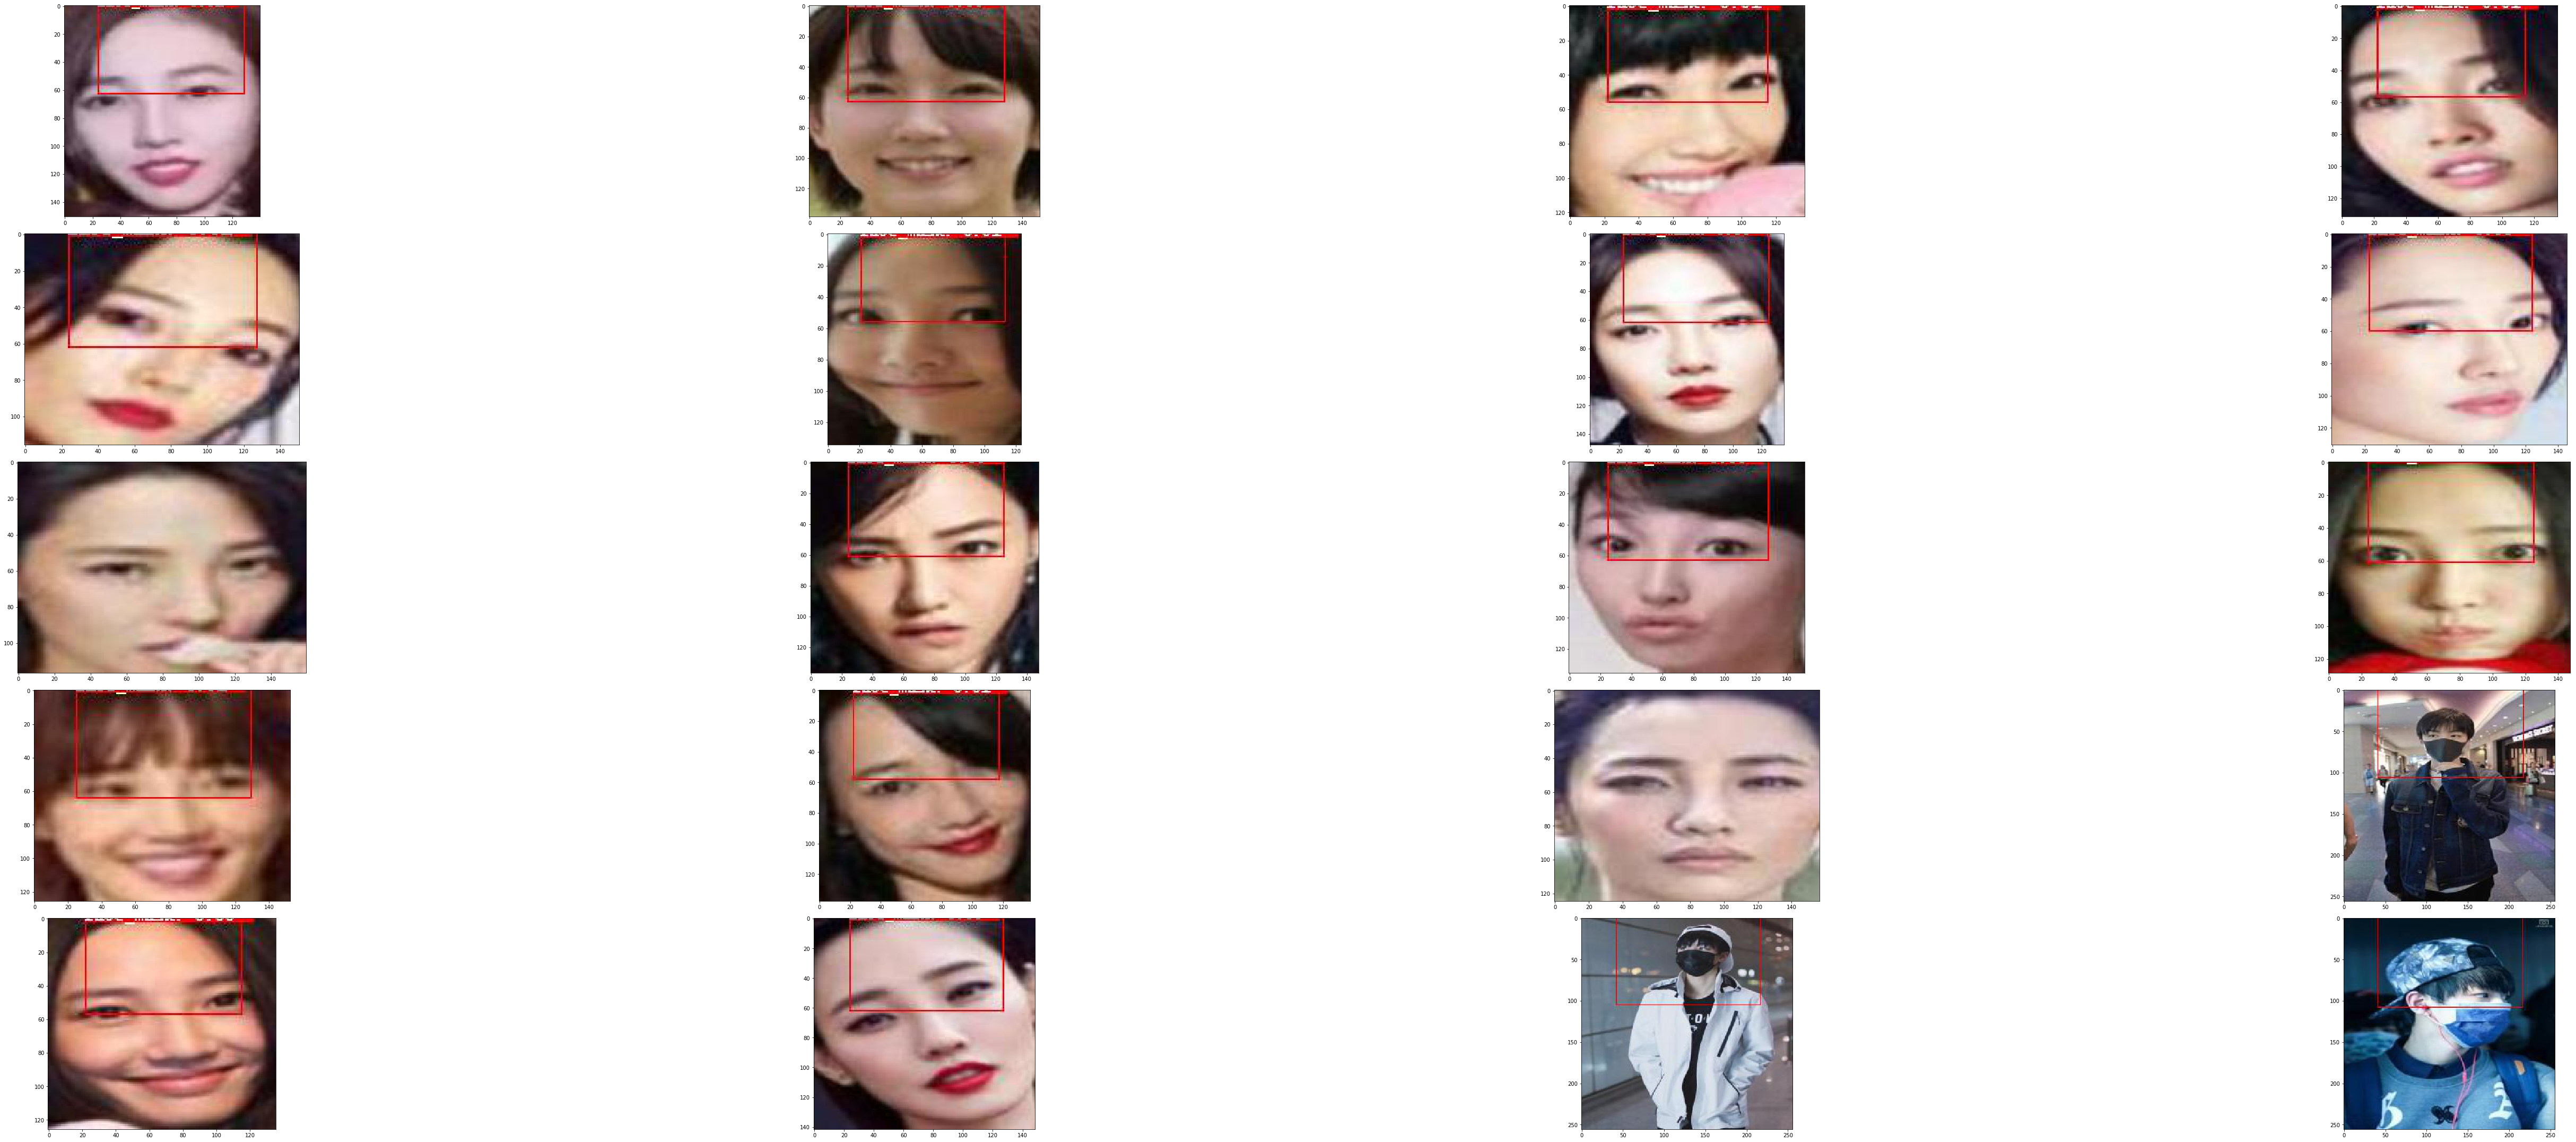

In [91]:
# 在这里执行可视化工具
OUTPUT_PATH = "data/infered_images" # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 20 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 9. 模型的导出和部署! <a class="anchor" id="head-9"></a>

In [93]:
!mkdir -p $USER_EXPERIMENT_DIR/export
# 这里导出的是FP32数据类型的模型，您可以通过更改--data_type的参数来更改导出的模型的数据精度
# 比如您可以设置--data_type fp16
!tlt-export ssd -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_mobilenet_v2_epoch_$EPOCH.tlt \
                -k $KEY \
                -o $USER_EXPERIMENT_DIR/export/ssd_mobilenet_v2_epoch_040.etlt \
                -e $SPECS_DIR/ssd_retrain_mobilenet_v2_kitti.txt  \
                --batch_size 1 \
                --data_type fp32

# 这里有直接导出INT 8 的数据类型的模型的命令 \
# !tlt-export ssd -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/ssd_resnet18_epoch_$EPOCH.tlt  \
#                 -o $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt \
#                 -e $SPECS_DIR/ssd_retrain_resnet18_kitti.txt \
#                 -k $KEY \
#                 --cal_image_dir  $USER_EXPERIMENT_DIR/data/testing/image_2 \
#                 --data_type int8 \
#                 --batch_size 1 \
#                 --batches 10 \
#                 --cal_cache_file $USER_EXPERIMENT_DIR/export/cal.bin  \
#                 --cal_data_file $USER_EXPERIMENT_DIR/export/cal.tensorfile

Using TensorFlow backend.
2020-07-01 12:13:22,051 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_retrain_mobilenet_v2_kitti.txt
2020-07-01 12:13:25,370 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_retrain_mobilenet_v2_kitti.txt
NOTE: UFF has been tested with TensorFlow 1.14.0.
Converting NMS as custom op: NMS_TRT
Converting FirstDimTile_5 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_4 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_3 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_2 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_1 as custom op: BatchTilePlugin_TRT
Converting FirstDimTile_0 as custom op: BatchTilePlugin_TRT
DEBUG [/usr/lib/python2.7/dist-packages/uff/converters/tensorflow/converter.py:96] 

In [94]:
# 这里展示了tlt-export所有的参数
!tlt-export

Using TensorFlow backend.
usage: tlt-export [-h] -m MODEL -k KEY [-o OUTPUT_FILE]
                  [--cal_data_file CAL_DATA_FILE]
                  [--cal_image_dir CAL_IMAGE_DIR]
                  [--data_type {fp32,fp16,int8}]
                  [--cal_cache_file CAL_CACHE_FILE] [--batches BATCHES]
                  [--max_workspace_size MAX_WORKSPACE_SIZE]
                  [--max_batch_size MAX_BATCH_SIZE] [--batch_size BATCH_SIZE]
                  [-e EXPERIMENT_SPEC] [--engine_file ENGINE_FILE] [-v]
                  {classification,detectnet_v2,ssd,dssd,faster_rcnn,yolo,retinanet}
tlt-export: error: too few arguments


In [95]:
# 这里查看导出的模型
print('导出模型:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/export

导出模型:
------------
total 3.4M
-rw-r--r-- 1 root root 3.4M Jul  1 12:13 ssd_mobilenet_v2_epoch_040.etlt


您可以通过Docker里面自带的`tlt-converter`工具来转换模型
`tlt-converter`工具将会将您训练出来的.etlt模型直接转换成可以部署在NVIDIA TensorRT和Deepstream 上的格式。对于x86设备，您可以直接复制docker中的工具到您自己的环境中
但是对于Jetson设备，您需要从下面的网址下载
[https://developer.nvidia.com/tlt-converter](https://developer.nvidia.com/tlt-converter)

In [96]:
# 转换成TensorRT engine (FP32)
!tlt-converter -k $KEY \
               -d 3,300,300 \
               -o NMS \
               -e $USER_EXPERIMENT_DIR/export/trt--mobilenet_v2_epoch_040.engine \
               -m 1 \
               -t fp32 \
               -i nchw \
               $USER_EXPERIMENT_DIR/export/ssd_mobilenet_v2_epoch_040.etlt

# Uncomment to convert to TensorRT engine (INT8).
# !tlt-converter -k $KEY  \
#                -d 3,384,1248 \
#                -o NMS \
#                -c $USER_EXPERIMENT_DIR/export/cal.bin \
#                -e $USER_EXPERIMENT_DIR/export/trt.engine \
#                -b 8 \
#                -m 1 \
#                -t int8 \
#                -i nchw \
#                $USER_EXPERIMENT_DIR/export/ssd_resnet18_epoch_$EPOCH.etlt

[INFO] Detected 1 inputs and 2 output network tensors.


In [97]:
#查看转换好的推理引擎
print('Exported engine:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/export/trt*.engine

Exported engine:
------------
-rw-r--r-- 1 root root 4.1M Jul  1 12:14 /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/export/trt--mobilenet_v2_epoch_040.engine


## 10. 确认导出模型 <a class="anchor" id="head-10"></a>
通过下面的命令来确认导出的engine文件是否可以正确运行

In [98]:
# 使用TensorRT engine文件进行推理
# 注意这里的tlt-infer 工具只支持batchsize为1，这点非常重要. 
# 所以请确认在使用tlt-converter工具时 ,使用`-m 1 --batch_size 1`为参数


!tlt-infer ssd --trt -p $USER_EXPERIMENT_DIR/export/trt--mobilenet_v2_epoch_040.engine \
                     -e $SPECS_DIR/ssd_train_mobilenet_v2_kitti.txt \
                     -i $DATA_DOWNLOAD_DIR/infer_images \
                     -o $USER_EXPERIMENT_DIR/ssd_infer_images \
                     -t 0.4

Using TensorFlow backend.
2020-07-01 12:15:25,517 [INFO] /usr/local/lib/python2.7/dist-packages/iva/ssd/utils/spec_loader.pyc: Merging specification from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/specs/ssd_train_mobilenet_v2_kitti.txt
2020-07-01 12:15:25,519 [INFO] iva.ssd.scripts.inference_trt: Loading cached TensorRT engine from /workspace/tlt_docker_files/mydata/tlt-tensorrt-nano/export/trt--mobilenet_v2_epoch_040.engine
[TensorRT] WARNING: Current optimization profile is: 0. Please ensure there are no enqueued operations pending in this context prior to switching profiles
100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 95.56it/s]


In [99]:
!echo $KEY

OHB1YTZ0Z2RxYTBzdnE3YTNpcnVydmM4cXI6MDM5MjNmZmUtYzFkMS00ZDFhLWIyOGEtM2M5N2RkZGZjNDZm
